### Implementación del modelo base

In [21]:
# Imports necesarios
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from lightgbm import early_stopping, log_evaluation
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
validation_treshold = 0.5

In [23]:
df_featured = pd.read_csv("./feature_engineering_work/dataset_feature_engineering_featured.csv")

In [24]:
print("Dimensiones del dataset:", df_featured.shape)
print("Columnas en el dataset:", df_featured.columns.tolist())

Dimensiones del dataset: (1852394, 112)
Columnas en el dataset: ['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'amt_month', 'amt_year', 'amt_month_shopping_net_spend', 'count_month_shopping_net', 'first_time_at_merchant', 'dist_between_client_and_merch', 'trans_month', 'trans_day', 'hour', 'year', 'times_shopped_at_merchant', 'times_shopped_at_merchant_year', 'times_shopped_at_merchant_month', 'times_shopped_at_merchant_day', 'transaction_dt', 'hour_of_day', 'day_of_week', 'is_weekend', 'is_night', 'day_of_month', 'week_of_month', 'time_of_day', 'dob_dt', 'age', 'amt_category', 'amt_to_monthly_ratio', 'amt_to_yearly_ratio', 'amt_deviation_from_category_avg', 'amt_percentile_in_category', 'distance_bin', 'distance_amount_ratio', 'dist_zscore', 'is_unusual_distance', 'days_since_last_purchase', 'trans_freq_ratio', 'trans_freq_mo

In [25]:
# Convertir variables categóricas a numéricas
categorical_columns = df_featured.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nColumnas categóricas a codificar: {categorical_columns}")

exclude_columns = ['cc_num', 'merchant', 'transaction_dt', 'dob', 'dob_dt', 'day_name', 'job']
for col in exclude_columns:
    if col in categorical_columns:
        categorical_columns.remove(col)


Columnas categóricas a codificar: ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'transaction_dt', 'time_of_day', 'dob_dt', 'amt_category', 'distance_bin', 'merchant_type', 'pop_category', 'day_name', 'job_category']


In [26]:
# Codificador para variables categóricas
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_featured[col + '_encoded'] = le.fit_transform(df_featured[col].astype(str))
    label_encoders[col] = le

In [27]:
# Definir features a utilizar
numeric_columns = df_featured.select_dtypes(include=[np.number]).columns.tolist()
features = [col for col in numeric_columns if col not in ['is_fraud'] + exclude_columns]

print(f"\nNúmero de características utilizadas: {len(features)}")
print(features)

df_featured['timestamp'] = pd.to_datetime(df_featured['unix_time'], unit='s')
df_featured = df_featured.sort_values('timestamp')


Número de características utilizadas: 66
['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'amt_month', 'amt_year', 'amt_month_shopping_net_spend', 'count_month_shopping_net', 'dist_between_client_and_merch', 'trans_month', 'trans_day', 'hour', 'year', 'times_shopped_at_merchant', 'times_shopped_at_merchant_year', 'times_shopped_at_merchant_month', 'times_shopped_at_merchant_day', 'hour_of_day', 'day_of_week', 'is_weekend', 'is_night', 'day_of_month', 'week_of_month', 'age', 'amt_to_monthly_ratio', 'amt_to_yearly_ratio', 'amt_deviation_from_category_avg', 'amt_percentile_in_category', 'distance_amount_ratio', 'dist_zscore', 'is_unusual_distance', 'days_since_last_purchase', 'trans_freq_ratio', 'trans_freq_month_ratio', 'trans_freq_day_ratio', 'merchant_multi_category', 'gender_encoded', 'first_time_distance_interaction', 'first_time_amount_interaction', 'transaction_uniqueness_score', 'shopping_net_ratio', 'lat_diff', 'long_diff', 'amt_zscore', 'is_unus

In [28]:
df_featured['timestamp']

0         2012-01-01 00:00:18
1         2012-01-01 00:00:44
2         2012-01-01 00:00:51
3         2012-01-01 00:01:16
4         2012-01-01 00:03:06
                  ...        
1852389   2013-12-31 23:59:07
1852390   2013-12-31 23:59:09
1852391   2013-12-31 23:59:15
1852392   2013-12-31 23:59:24
1852393   2013-12-31 23:59:34
Name: timestamp, Length: 1852394, dtype: datetime64[ns]

In [29]:
test_df = df_featured[df_featured['timestamp'].dt.month == 12]
train_df = df_featured[~df_featured.index.isin(test_df.index)]

print(f"\nTamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")
print(f"Rango de fechas en entrenamiento: {train_df['timestamp'].min()} a {train_df['timestamp'].max()}")
print(f"Rango de fechas en prueba: {test_df['timestamp'].min()} a {test_df['timestamp'].max()}")

# Preparar los datos para el entrenamiento
X_train = train_df[features]
y_train = train_df['is_fraud']
X_test = test_df[features]
y_test = test_df['is_fraud']


Tamaño del conjunto de entrenamiento: 1571796
Tamaño del conjunto de prueba: 280598
Rango de fechas en entrenamiento: 2012-01-01 00:00:18 a 2013-11-30 23:59:45
Rango de fechas en prueba: 2012-12-01 00:00:10 a 2013-12-31 23:59:34


In [30]:
# Crear conjuntos de datos de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [31]:
# Parámetros para el modelo base
params_base = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'min_data_in_leaf': 30,
    'max_depth': 6,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

In [32]:
# Entrenamiento del modelo base
model_base = lgb.train(
    params_base,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.998061
[200]	valid_0's auc: 0.998178
Early stopping, best iteration is:
[160]	valid_0's auc: 0.998341


In [33]:
y_pred_proba_base = model_base.predict(X_test, num_iteration=model_base.best_iteration)
y_pred_base = (y_pred_proba_base > validation_treshold).astype(int)

auc_base = roc_auc_score(y_test, y_pred_proba_base)
f1_base = f1_score(y_test, y_pred_base)

report_base = classification_report(y_test, y_pred_base, digits=4)
print(report_base)
# precision_base = report_base['1']['precision']
# recall_base = report_base['1']['recall']
# f1_base = report_base['1']['f1-score']
# support_base = report_base['1']['support']

conf_matrix_base = confusion_matrix(y_test, y_pred_base)
tn, fp, fn, tp = conf_matrix_base.ravel()

ratio_fp_base = (tp + fp) / tp if tp > 0 else float('inf')

print("\nMétricas del modelo base:")
# print(f"Precision: {precision_base:.4f}")
# print(f"Recall (Detección de fraude): {recall_base:.4f} ({tp}/{tp+fn})")
print(f"F1-Score: {f1_base:.4f}")
# print(f"Support: {support_base}")
print(f"AUC-ROC: {auc_base:.4f}")
print(f"Ratio de falsos positivos: {ratio_fp_base:.4f}")
print(f"Falsos positivos: {fp}")
print(f"Matriz de confusión:\n{conf_matrix_base}")


              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9995    279748
           1     0.8869    0.8024    0.8425       850

    accuracy                         0.9991    280598
   macro avg     0.9431    0.9010    0.9210    280598
weighted avg     0.9991    0.9991    0.9991    280598


Métricas del modelo base:
F1-Score: 0.8425
AUC-ROC: 0.9983
Ratio de falsos positivos: 1.1276
Falsos positivos: 87
Matriz de confusión:
[[279661     87]
 [   168    682]]


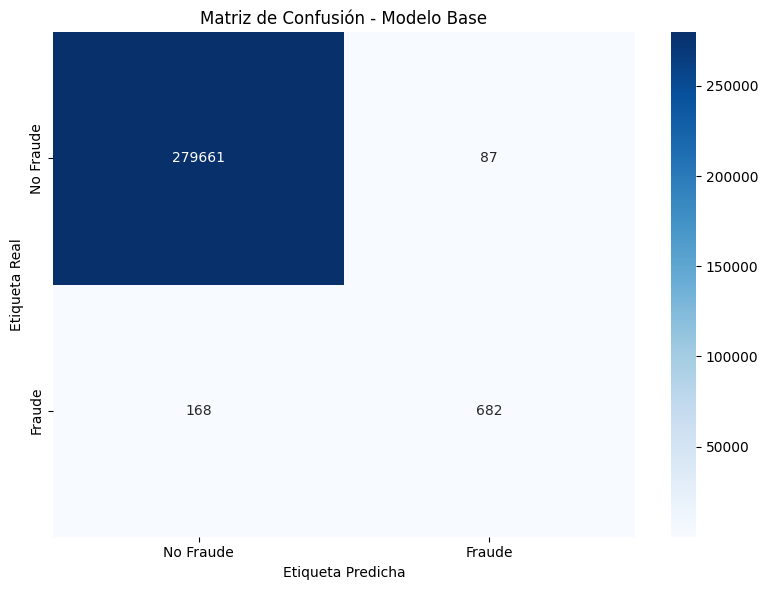

In [34]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_base, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraude', 'Fraude'], 
            yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión - Modelo Base')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

### Definición de métricas personalizadas

In [35]:
# def ratio_falsos_positivos_eval(y_pred, dtrain):
#     y_true = dtrain.get_label()
#     y_pred_binary = (y_pred > 0.5).astype(int)
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
#     ratio = (tp + fp) / tp if tp > 0 else float('inf')
#     return 'ratio_fp', ratio, True

def ratio_falsos_positivos_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)

    tp = ((y_true == 1) & (y_pred_binary == 1)).sum()
    fp = ((y_true == 0) & (y_pred_binary == 1)).sum()

    ratio = (tp + fp) / tp if tp > 0 else float('inf')
    return 'ratio_fp', ratio, True


In [36]:
def balanced_fp_detection_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    fp_ratio = fp / (fp + tn) if (fp + tn) > 0 else 1

    # Penalización más progresiva y más énfasis en detection
    score = (1 - detection_rate)**2 + (fp_ratio)**2
    
    return 'balanced_fp_det_v2', score, False  # False: menor es mejor


#### Primera métrica personalizada

In [37]:
params_custom1 = params_base.copy()
params_custom1['metric'] = 'None'
params_custom1['early_stopping_round'] = 50

model_custom1 = lgb.train(
    params_custom1,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    feval=ratio_falsos_positivos_eval,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's ratio_fp: 1.142
Early stopping, best iteration is:
[93]	valid_0's ratio_fp: 1.1435


In [38]:
y_pred_proba_custom1 = model_custom1.predict(X_test, num_iteration=model_custom1.best_iteration)
y_pred_custom1 = (y_pred_proba_custom1 > validation_treshold).astype(int)

report = classification_report(y_test, y_pred_custom1, digits=4)
print(report)
# precision = report['1']['precision']
# recall = report['1']['recall']
# f1 = report['1']['f1-score']
# support = report['1']['support']
auc = roc_auc_score(y_test, y_pred_proba_custom1)

conf_matrix = confusion_matrix(y_test, y_pred_custom1)
tn, fp, fn, tp = conf_matrix.ravel()
ratio_fp = (tp + fp) / tp if tp > 0 else float('inf')

print("\nMétricas del modelo con balance entre falsos positivos y detección:")
# print(f"Precision: {precision:.4f}")
# print(f"Recall (Detección de fraude): {recall:.4f} ({tp}/{tp+fn})")
# print(f"F1-Score: {f1:.4f}")
# print(f"Support: {support}")
print(f"AUC-ROC: {auc:.4f}")
print(f"Ratio de falsos positivos: {ratio_fp:.4f}")
print(f"Falsos positivos: {fp}")
print(f"Matriz de confusión:\n{conf_matrix}")


              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9995    279748
           1     0.8745    0.7871    0.8285       850

    accuracy                         0.9990    280598
   macro avg     0.9369    0.8934    0.9140    280598
weighted avg     0.9990    0.9990    0.9990    280598


Métricas del modelo con balance entre falsos positivos y detección:
AUC-ROC: 0.9979
Ratio de falsos positivos: 1.1435
Falsos positivos: 96
Matriz de confusión:
[[279652     96]
 [   181    669]]


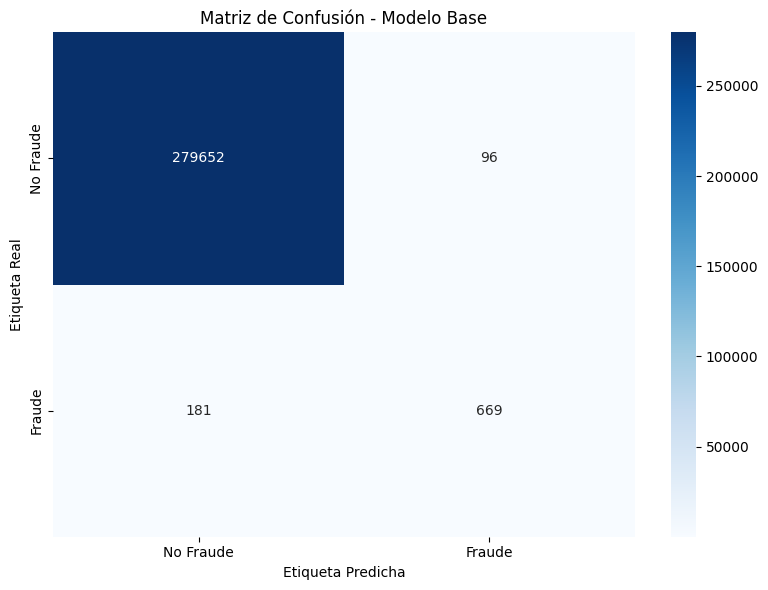

In [39]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraude', 'Fraude'], 
            yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión - Modelo Base')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

#### Segunda métrica personalizada

In [40]:
params_custom2 = params_base.copy()
params_custom2['metric'] = 'None'

model_custom2 = lgb.train(
    params_custom2,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    feval=balanced_fp_detection_eval,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's balanced_fp_det_v2: 0.0453441
[200]	valid_0's balanced_fp_det_v2: 0.0376818
Early stopping, best iteration is:
[231]	valid_0's balanced_fp_det_v2: 0.0376818


In [41]:
y_pred_proba_custom2 = model_custom2.predict(X_test, num_iteration=model_custom2.best_iteration)
y_pred_custom2 = (y_pred_proba_custom2 > validation_treshold).astype(int)

report = classification_report(y_test, y_pred_custom2, digits=4)
print(report)
# precision = report['1']['precision']
# recall = report['1']['recall']
# f1 = report['1']['f1-score']
# support = report['1']['support']
auc = roc_auc_score(y_test, y_pred_proba_custom2)

conf_matrix = confusion_matrix(y_test, y_pred_custom2)
tn, fp, fn, tp = conf_matrix.ravel()
ratio_fp = (tp + fp) / tp if tp > 0 else float('inf')

print("\nMétricas del modelo con balance entre falsos positivos y detección:")
# print(f"Precision: {precision:.4f}")
# print(f"Recall (Detección de fraude): {recall:.4f} ({tp}/{tp+fn})")
# print(f"F1-Score: {f1:.4f}")
# print(f"Support: {support}")
print(f"AUC-ROC: {auc:.4f}")
print(f"Ratio de falsos positivos: {ratio_fp:.4f}")
print(f"Falsos positivos: {fp}")
print(f"Matriz de confusión:\n{conf_matrix}")


              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9996    279748
           1     0.8896    0.8059    0.8457       850

    accuracy                         0.9991    280598
   macro avg     0.9445    0.9028    0.9226    280598
weighted avg     0.9991    0.9991    0.9991    280598


Métricas del modelo con balance entre falsos positivos y detección:
AUC-ROC: 0.9981
Ratio de falsos positivos: 1.1241
Falsos positivos: 85
Matriz de confusión:
[[279663     85]
 [   165    685]]


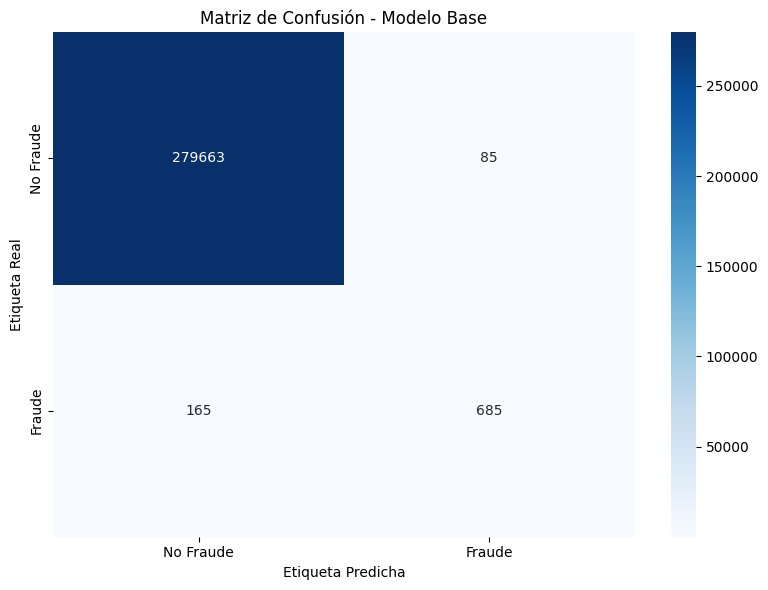

In [42]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraude', 'Fraude'], 
            yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión - Modelo Base')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

### Evaluación de resultados

In [43]:
thresholds = np.arange(0.1, 0.95, 0.05)
metrics_by_threshold = []

for model_name, y_proba in [("Base", y_pred_proba_base), 
                            ("Custom1", y_pred_proba_custom1), 
                            ("Custom2", y_pred_proba_custom2)]:
    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        ratio_fp = (tp + fp) / tp if tp > 0 else float('inf')
        
        metrics_by_threshold.append({
            'model': model_name,
            'threshold': threshold,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp,
            'detection_rate': detection_rate,
            'ratio_fp': ratio_fp,
            'auc': roc_auc_score(y_test, y_proba),
            'f1': f1_score(y_test, y_pred)
        })


In [44]:
metrics_df = pd.DataFrame(metrics_by_threshold)
high_detection_df = metrics_df[metrics_df['detection_rate'] >= 0.9]

if not high_detection_df.empty:
    best_model = high_detection_df.sort_values('ratio_fp').iloc[0]
    
    print("\nMejor modelo con detección >= 90%:")
    print(f"Modelo: {best_model['model']}")
    print(f"Umbral: {best_model['threshold']:.2f}")
    print(f"Ratio de falsos positivos: {best_model['ratio_fp']:.4f}")
    print(f"Detección de fraude: {best_model['detection_rate']:.4f} ({best_model['true_positives']}/{best_model['true_positives'] + best_model['false_negatives']})")
    print(f"Falsos positivos: {best_model['false_positives']}")
    print(f"AUC-ROC: {best_model['auc']:.4f}")
    print(f"F1-Score: {best_model['f1']:.4f}")
else:
    print("\nNo se encontró ningún modelo con detección >= 90%")
    best_detection = metrics_df.sort_values('detection_rate', ascending=False).head(1)
    print(f"\nModelo con mayor detección:")
    print(f"Modelo: {best_detection['model'].values[0]}")
    print(f"Umbral: {best_detection['threshold'].values[0]:.2f}")
    print(f"Detección: {best_detection['detection_rate'].values[0]:.4f}")
    print(f"Ratio de falsos positivos: {best_detection['ratio_fp'].values[0]:.4f}")

plt.figure(figsize=(12, 8))


No se encontró ningún modelo con detección >= 90%

Modelo con mayor detección:
Modelo: Custom2
Umbral: 0.10
Detección: 0.8835
Ratio de falsos positivos: 1.7377


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

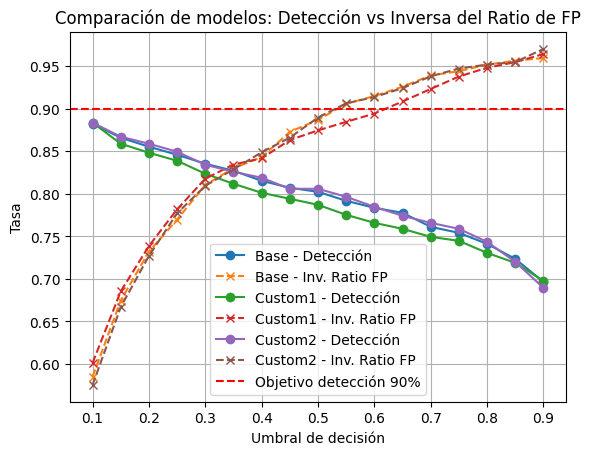

In [45]:
for model_name in ["Base", "Custom1", "Custom2"]:
    model_data = metrics_df[metrics_df['model'] == model_name]
    plt.plot(model_data['threshold'], model_data['detection_rate'], 
             marker='o', linestyle='-', label=f"{model_name} - Detección")
    plt.plot(model_data['threshold'], 1/model_data['ratio_fp'], 
             marker='x', linestyle='--', label=f"{model_name} - Inv. Ratio FP")

plt.axhline(y=0.9, color='r', linestyle='--', label="Objetivo detección 90%")
plt.xlabel('Umbral de decisión')
plt.ylabel('Tasa')
plt.title('Comparación de modelos: Detección vs Inversa del Ratio de FP')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x1000 with 0 Axes>

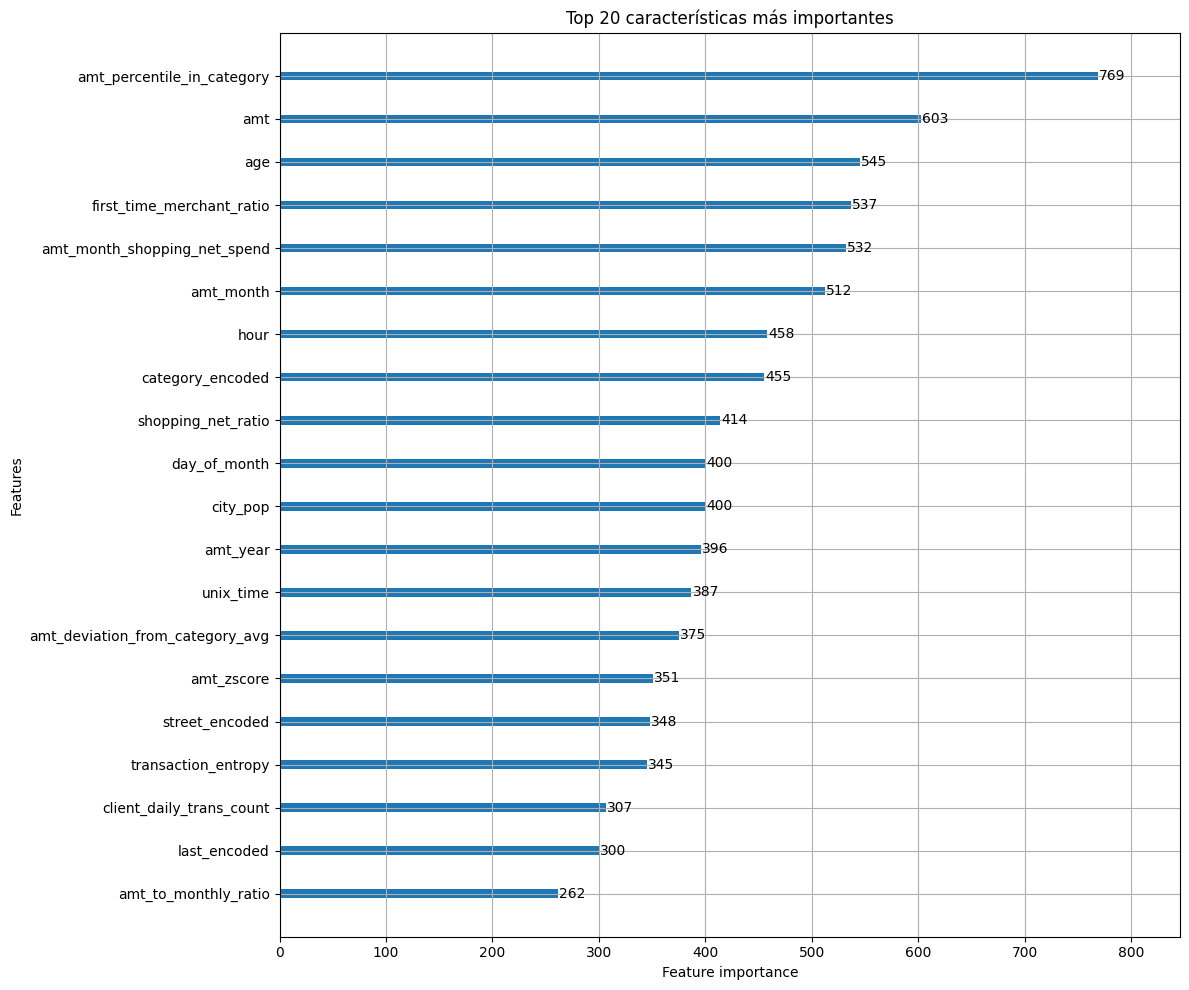

In [46]:
plt.figure(figsize=(12, 10))
lgb.plot_importance(model_custom2, max_num_features=20, figsize=(12, 10))
plt.title('Top 20 características más importantes')
plt.tight_layout()
plt.show()

In [47]:
if not high_detection_df.empty:
    best_model_name = best_model['model']
    if best_model_name == "Base":
        best_model_obj = model_base
    elif best_model_name == "Custom1":
        best_model_obj = model_custom1
    else:
        best_model_obj = model_custom2
    
    best_model_obj.save_model(f"mejor_modelo_{best_model_name}.txt")
    print(f"\nModelo guardado como mejor_modelo_{best_model_name}.txt")

### Conclusión